In [872]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [873]:
db_config = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': 5432
}
conn = psycopg2.connect(**db_config)

query = "SELECT * FROM flats_rent;"  

df = pd.read_sql(query, conn)

conn.close()

# Display the first few rows of the DataFrame
df.head()

/var/folders/dw/bq8hw9m10lg3bb2w7y35cc8m0000gn/T/ipykernel_45267/2479054647.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [875]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9325 entries, 0 to 9324
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            9325 non-null   int64 
 1   city          9325 non-null   object
 2   district      8278 non-null   object
 3   price         9325 non-null   int64 
 4   rooms         9325 non-null   int64 
 5   planing       7395 non-null   object
 6   square        9325 non-null   int64 
 7   actual_floor  9325 non-null   int64 
 8   last_floor    9325 non-null   int64 
 9   building      4766 non-null   object
 10  children      3822 non-null   object
 11  pets          2626 non-null   object
 12  link          9325 non-null   object
dtypes: int64(6), object(7)
memory usage: 947.2+ KB


In [876]:
# Fill NaN fields
df['district'] = df['district'].fillna('Undefined')
df['planing'] = df['planing'].fillna('Undefined')
df['building'] = df['building'].fillna('Undefined')
df['children'] = df['children'].fillna('Undefined')
df['pets'] = df['pets'].fillna('Undefined')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9325 entries, 0 to 9324
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            9325 non-null   int64 
 1   city          9325 non-null   object
 2   district      9325 non-null   object
 3   price         9325 non-null   int64 
 4   rooms         9325 non-null   int64 
 5   planing       9325 non-null   object
 6   square        9325 non-null   int64 
 7   actual_floor  9325 non-null   int64 
 8   last_floor    9325 non-null   int64 
 9   building      9325 non-null   object
 10  children      9325 non-null   object
 11  pets          9325 non-null   object
 12  link          9325 non-null   object
dtypes: int64(6), object(7)
memory usage: 947.2+ KB


In [ ]:
# Drop overoverwhelmingly expensive flats (price for sale not rent)
df = df[df['price'] <= 80000]
df['price_m2'] = df['price'] / df['square']
avarage_price_m2 = df['price_m2'].mean()
threshold = 1.5 * avarage_price_m2
df = df[df['price_m2']<=threshold]


541.9354838709677
361.42146344374703
80000


In [ ]:
# Drop flats with more than 4 rooms
df = df[df['rooms'] <= 4]
city_counts = df['city'].value_counts()

# Drop minor cities that have  less than 20 flats
min_occurrences = 20
df = df[df['city'].map(city_counts) >= min_occurrences]
city_counts = df['city'].value_counts()


city
Київ                             2353
Львів                            1503
Одеса                             855
Дніпро                            690
Харків                            626
Івано-Франківськ                  362
Хмельницький                      211
Житомир                           126
Рівне                              92
с. Софіївська борщагівка           77
Запоріжжя                          72
Тернопіль                          68
Полтава                            58
Чернівці                           47
Миколаїв                           45
Луцьк                              44
Вінниця                            39
Ужгород                            39
Суми                               33
Черкаси                            24
Кропивницький                      21
Чернігів                           20
с. Сокільники                      16
с. Петропавлівська борщагівка      14
Вишневе                            13
с. Новосілки                       13
смт. Бр

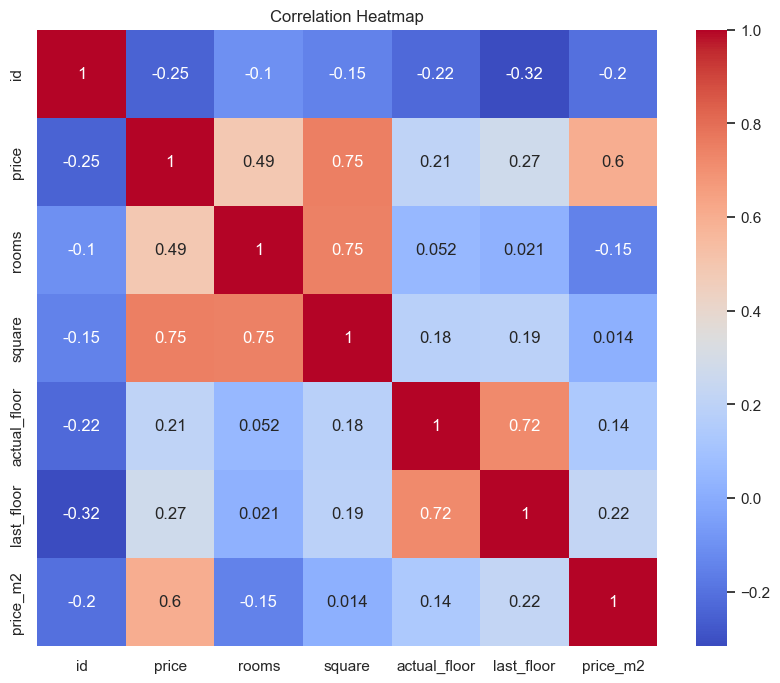

In [ ]:
# Select numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

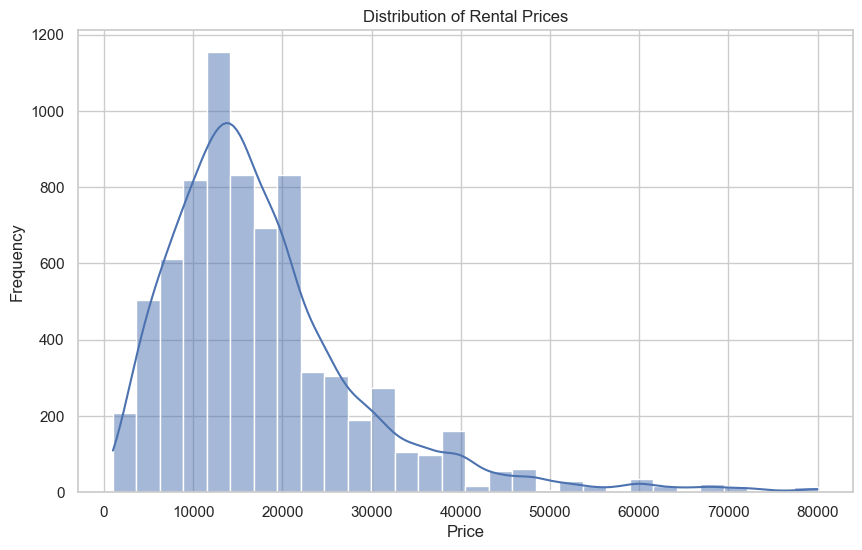

In [881]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

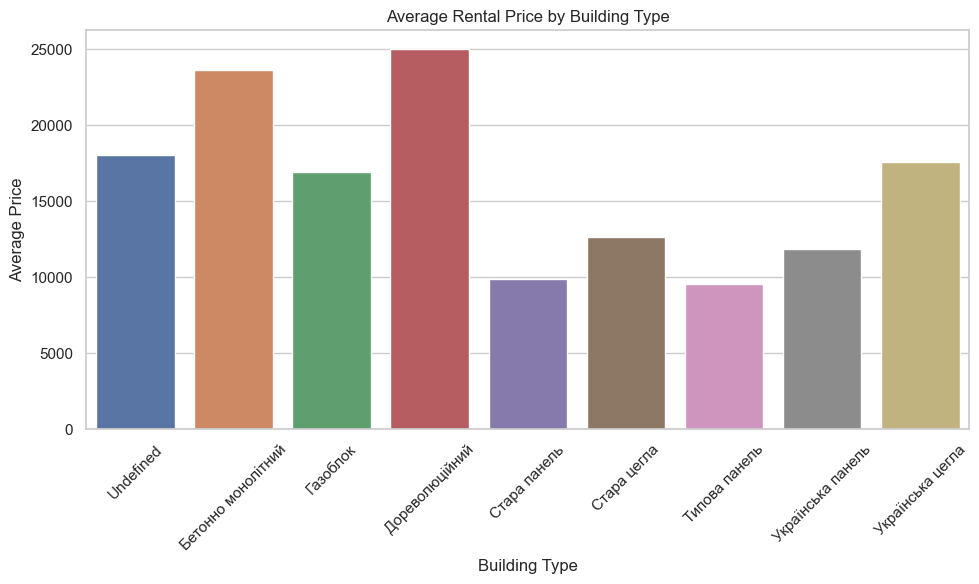

In [882]:
# Group by building type and calculate average price
avg_price_by_building = df.groupby('building')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='building', y='price', hue='building', data=avg_price_by_building)
plt.title('Average Rental Price by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


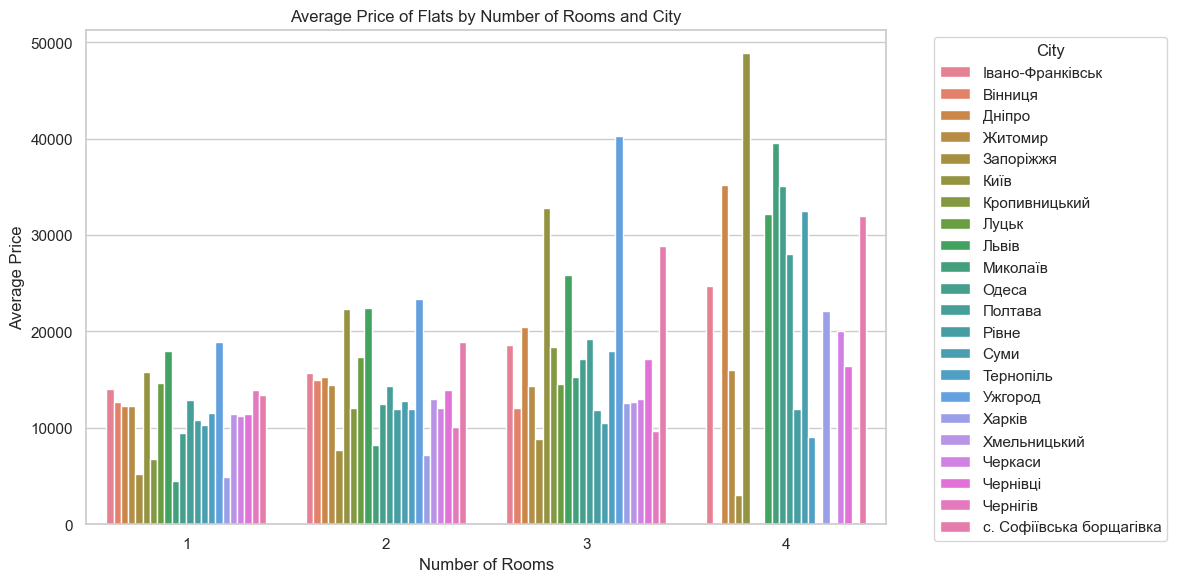

In [883]:
# Group by 'rooms' and 'city', then calculate the average price
grouped_data = df.groupby(['rooms', 'city'])['price'].mean().reset_index()

grouped_data_dict = {
    f'{room}_rooms': grouped_data[grouped_data['rooms'] == room]
    for room in grouped_data['rooms'].unique()
}

plt.figure(figsize=(12, 6))

sns.barplot(x='rooms', y='price', hue='city', data=grouped_data)

plt.title('Average Price/m2 of Flats by Number of Rooms and City')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')

plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

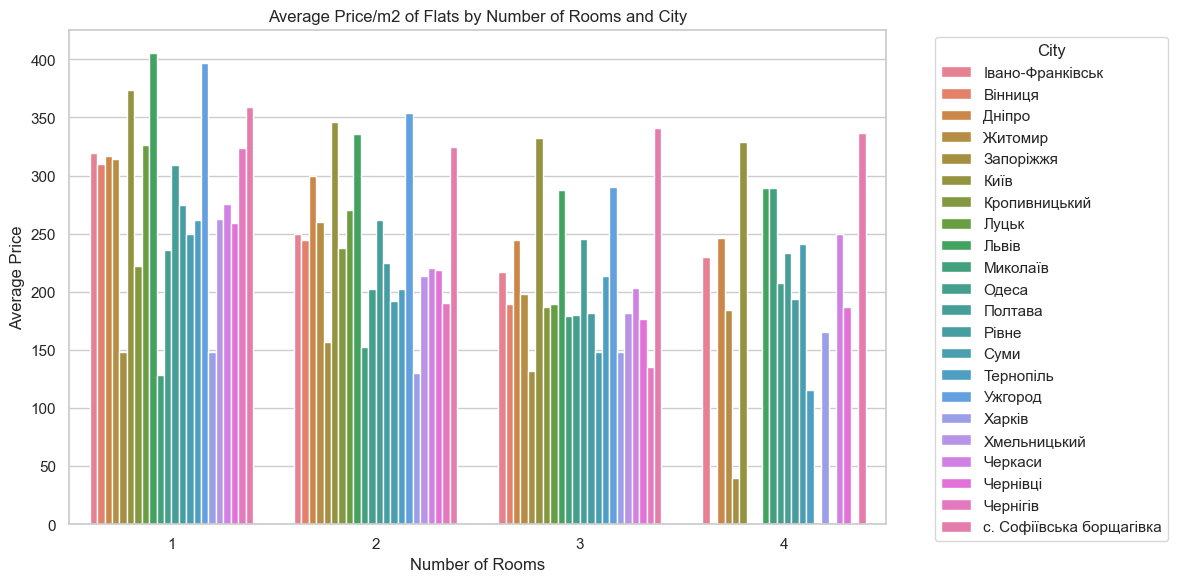

In [884]:
# Group by 'rooms' and 'city', then calculate the average price/m2
grouped_data = df.groupby(['rooms', 'city'])['price_m2'].mean().reset_index()

grouped_data_dict = {
    f'{room}_rooms': grouped_data[grouped_data['rooms'] == room]
    for room in grouped_data['rooms'].unique()
}

plt.figure(figsize=(12, 6))

sns.barplot(x='rooms', y='price_m2', hue='city', data=grouped_data)

plt.title('Average Price/m2 of Flats by Number of Rooms and City')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')

plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

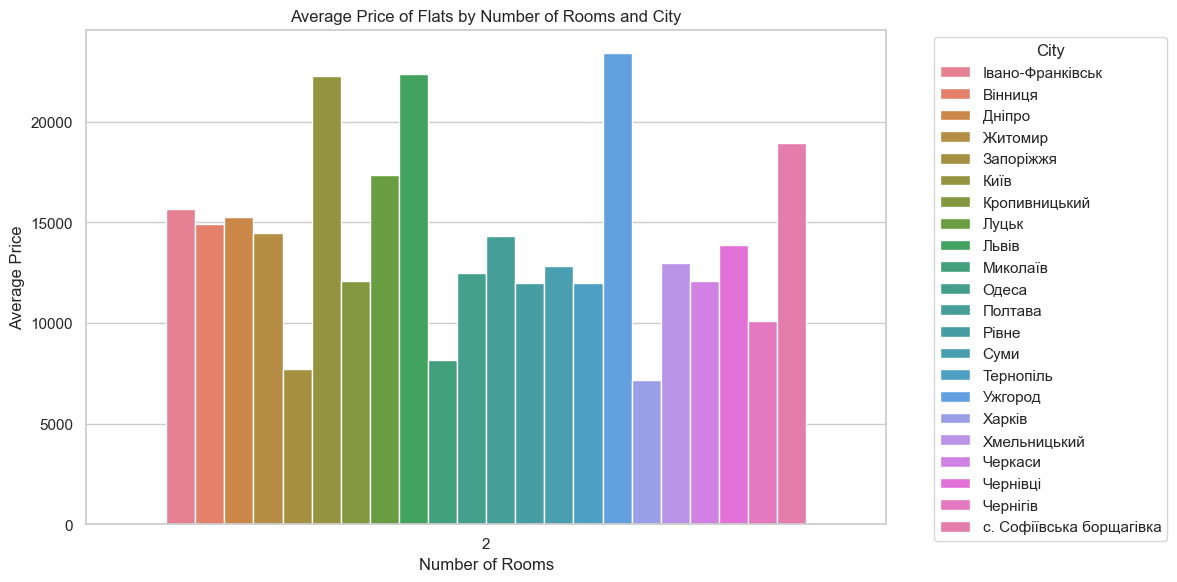

In [885]:
# Group by 'city', then calculate the average price for 2 rooms flats
grouped_data = df.groupby(['rooms', 'city'])['price'].mean().reset_index()

grouped_data_dict = {
    f'{room}_rooms': grouped_data[grouped_data['rooms'] == room]
    for room in grouped_data['rooms'].unique()
}


plt.figure(figsize=(12, 6))

sns.barplot(x='rooms', y='price', hue='city', data=grouped_data_dict["2_rooms"])

plt.title('Average Price of Flats with 2 Rooms and City')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')

plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

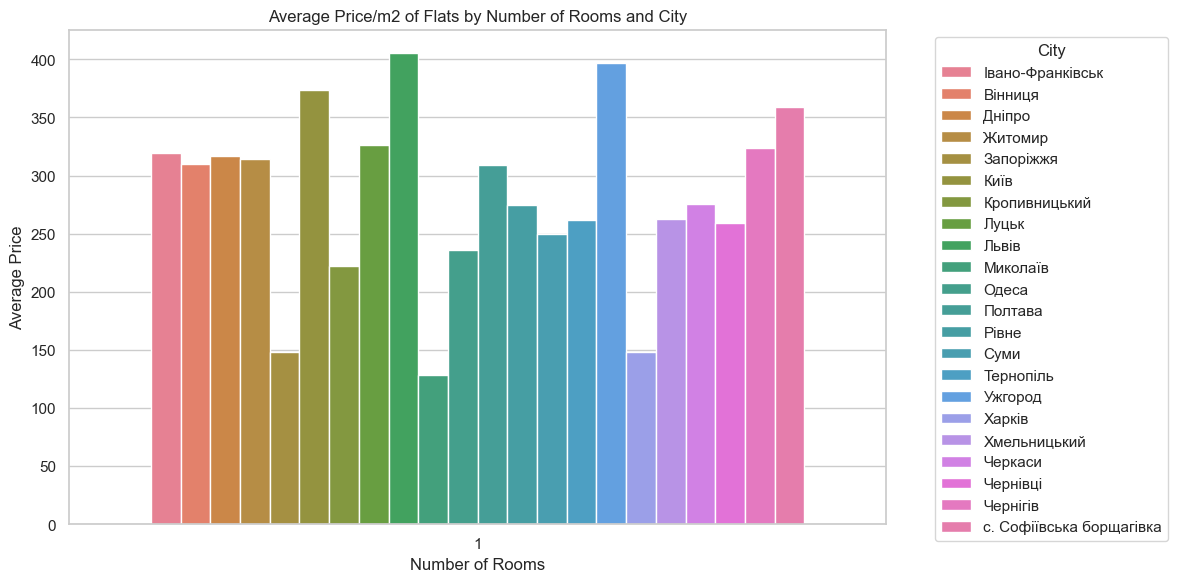

In [886]:
# Group by and 'city', then calculate the average price/m2 for 1 room flat
grouped_data = df.groupby(['rooms', 'city'])['price_m2'].mean().reset_index()

grouped_data_dict = {
    f'{room}_rooms': grouped_data[grouped_data['rooms'] == room]
    for room in grouped_data['rooms'].unique()
}

plt.figure(figsize=(12, 6))

sns.barplot(x='rooms', y='price_m2', hue='city', data=grouped_data_dict["1_rooms"])

plt.title('Average Price/m2 of Flats with 1 Room and City')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')

plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

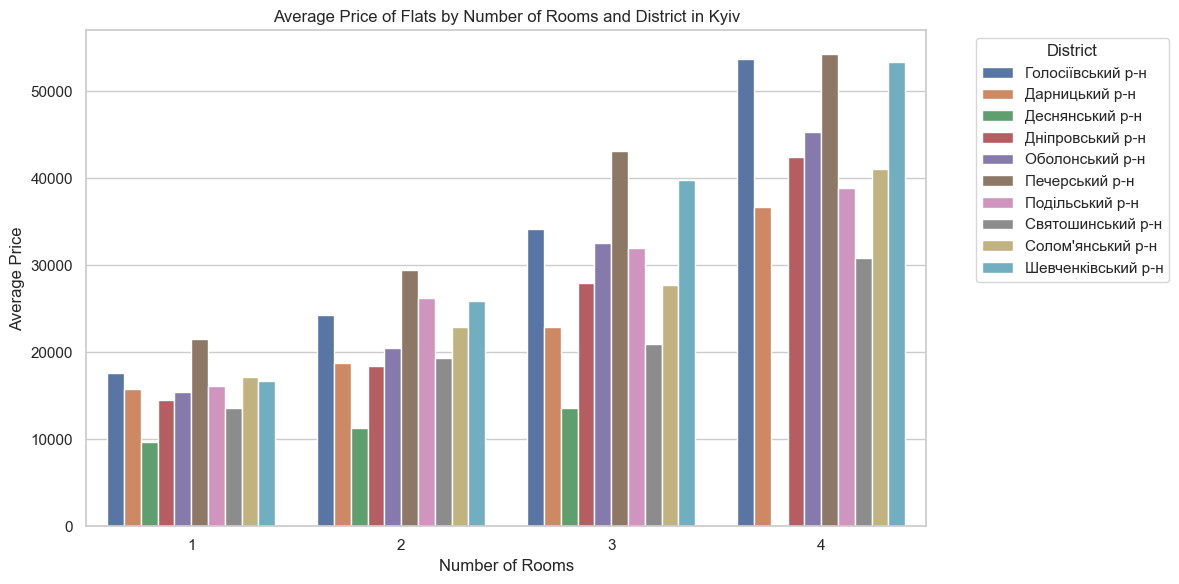

In [887]:
# Group by and 'district' and number of rooms in city 'Київ' then calculate the average price
city_kyiv_df = df[df['city'] == 'Київ']
grouped_data_city = city_kyiv_df.groupby(['rooms', 'district'])['price'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(x='rooms', y='price', hue='district', data=grouped_data_city)

plt.title('Average Price of Flats by Number of Rooms and District in Kyiv')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')

plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

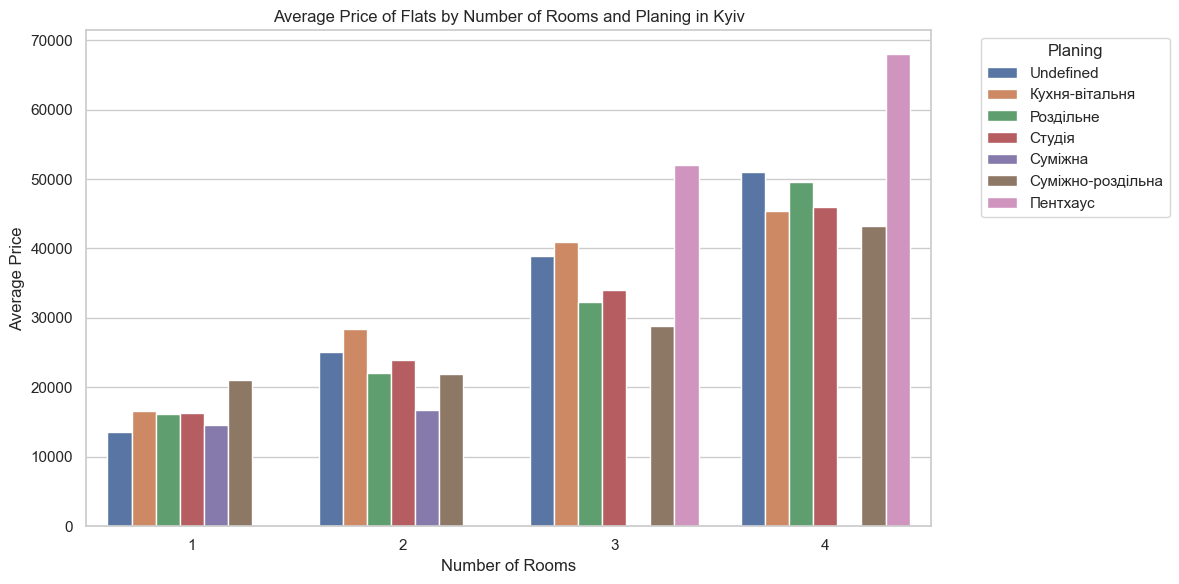

In [ ]:
# Group by and 'planing' and number of rooms in city 'Київ' then calculate the average price
city_kyiv_df = df[df['city'] == 'Київ']
grouped_data_city = city_kyiv_df.groupby(['rooms', 'planing'])['price'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(x='rooms', y='price', hue='planing', data=grouped_data_city)

plt.title('Average Price of Flats by Number of Rooms and Planing in Kyiv')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price')

plt.legend(title='Planing', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

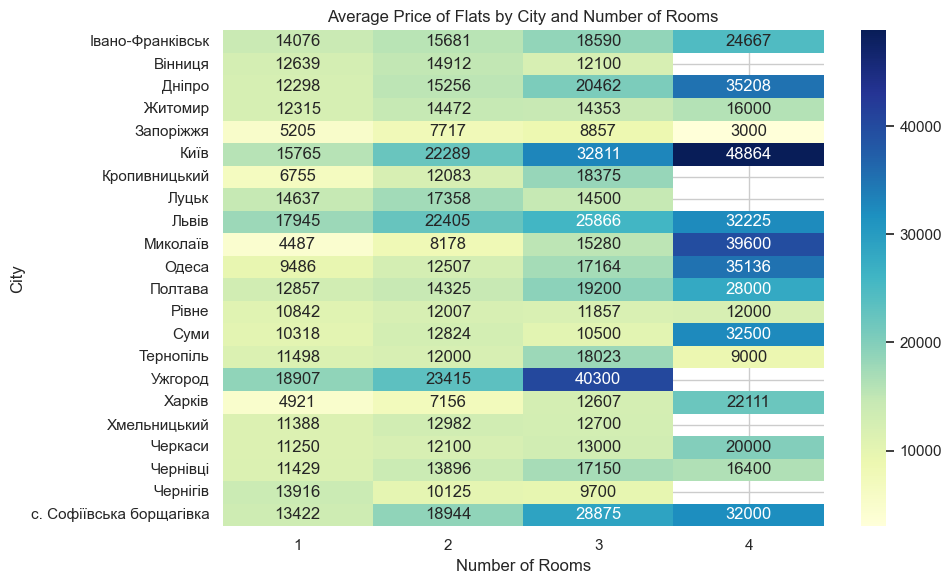

In [889]:
# Group by and 'rooms' and 'city' then calculate the average price
grouped_data = df.groupby(['rooms', 'city'])['price'].mean().reset_index()
heatmap_data = grouped_data.pivot(index='city', columns='rooms', values='price')

plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu')

plt.title('Average Price of Flats by City and Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('City')

plt.tight_layout()
plt.show()